In [392]:
import os
import numpy as np
import scipy.misc
from stylize import stylize
import math
from argparse import ArgumentParser

import vgg
import tensorflow as tf
import numpy as np
from sys import stderr

In [393]:
# default arguments
CONTENT_WEIGHT = 5e0
STYLE_WEIGHT = 1e2
TV_WEIGHT = 1e2
LEARNING_RATE = 1e1
STYLE_SCALE = 1.0
ITERATIONS = 1000
VGG_PATH = 'imagenet-vgg-verydeep-19.mat'

CONTENT_LAYER = 'relu4_2'
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

In [394]:
def imread(path):
    return scipy.misc.imread(path).astype(np.float)

In [395]:
class Args(dict):
    pass

options = Args()
options.content = 'examples/brad_pitt.jpg'
options.styles = ['examples/picasso_selfport1907.jpg']
options.output = 'examples/face_portrait.jpg'
options.iterations = 1
options.network = VGG_PATH
options.width = 512

In [396]:
content_image = imread(options.content)
style_images = [imread(style) for style in options.styles]

width = options.width
if width is not None:
    #compute new height according to the given width
    new_shape = (int(math.floor(float(content_image.shape[0]) /
            content_image.shape[1] * width)), width)
    content_image = scipy.misc.imresize(content_image, new_shape)

target_shape = content_image.shape
for i in range(len(style_images)):
    style_scale = STYLE_SCALE
    #resize style image according to width faction
    #style_images[i] = scipy.misc.imresize(style_images[i], style_scale *
    #target_shape[1] / style_images[i].shape[1])
    ###we limit style image size to be same as content image size
    style_images[i] = scipy.misc.imresize(style_images[0], target_shape)

In [397]:
content = content_image
styles = style_images
iterations = options.iterations
network = options.network

In [398]:
#initialize shape and features
shape = (1,) + content.shape
style_shapes = [(1,) + style.shape for style in styles]
content_features = {}
style_features = [{} for _ in styles]

In [399]:
g = tf.Graph()
# compute content features in feedforward mode
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    image = tf.placeholder('float', shape=shape)
    net, mean_pixel = vgg.net(network, image)
    content_pre = np.array([vgg.preprocess(content, mean_pixel)])
    content_features[CONTENT_LAYER] = net[CONTENT_LAYER].eval(
            feed_dict={image: content_pre})

In [400]:
# compute style features in feedforward mode
for i in range(len(styles)):
    g = tf.Graph()
    with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
        image = tf.placeholder('float', shape=style_shapes[i])
        net, _ = vgg.net(network, image)
        style_pre = np.array([vgg.preprocess(styles[i], mean_pixel)])
        for layer in STYLE_LAYERS:
            features = net[layer].eval(feed_dict={image: style_pre})
            features = np.reshape(features, (-1, features.shape[3]))
            gram = np.matmul(features.T, features) / features.size
            style_features[i][layer] = gram
        ###compute style content feature
        style_features[i][CONTENT_LAYER] = net[CONTENT_LAYER].eval(
                feed_dict={image: style_pre})

<img src="features.png">
To create a graph with certain content and style, we want to first acquire the features of these contents and styles as a standard. Which means, we want our image to have both features included in content image and features in style images. Unsurprisingly, neurons in neural network are a great way to extract these features according to its intuition. Thus, we utilize the pre-trained vgg network, input content image and style images and compute output of each layer in the network. Then, we choose some of the layers as features of the content and style.

After having those features in hand, how can we create the stylized image? If we have an image that has has all the features in content and style images, then this image is exatly what we want. So let's first solve this problem - given an image, how can we measure the difference between this image and ideal image that has all the features? One thing we could do is to input our image into the neural network, compute output in each layer, pick certain layer as its features and compare its feature with corresponding content and style feature. The comparison could achieved using the loss function. 

As we form the loss function, our goal becomes to find an image that minimizes this loss function. This goal can be easily achieved using [backpropagation method](http://colah.github.io/posts/2015-08-Backprop/) in neural network training process - We input a white noise image and use [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) to gradually change each pixel in the image to minimize the loss function.  


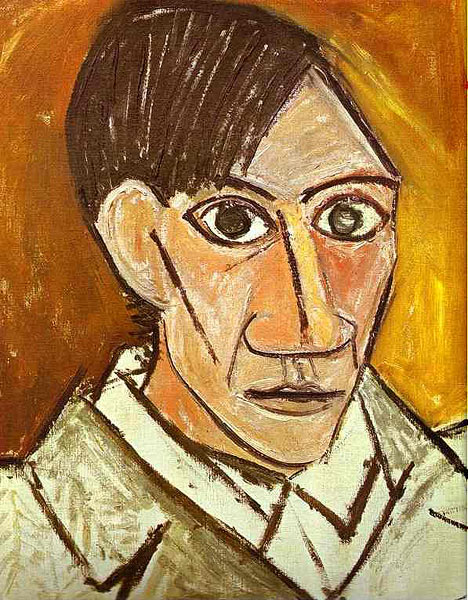

In [254]:
from PIL import Image
Image.open(options.styles[0])

<img src='face.png'>
Due to [1], there is always a tradeoff between gaining style or gaining content due to the loss function. One effort we are trying is to slow the deformation process when increasing the style-content ratio. Why this is important? When applying texture style to the portrait using [1], we encounter the deformation problem caused by feature space ???[2] Human eyes are very sensitive to face deformation. Thus, spacial constraints are required to maintain the face structure.

In [401]:
type(content_features[CONTENT_LAYER])
content_features[CONTENT_LAYER].shape

(1, 81, 64, 512)

In [269]:
CONTENT_LAYERS = ('relu1_1', 'relu1_2', 'relu2_1', 'relu2_2', 'relu3_1', 'relu3_2', 'relu3_3', 
                  'relu3_4', 'relu4_1', 'relu4_2', 'relu4_3', 'relu4_4', 'relu5_1', 'relu5_2',
                  'relu5_3', 'relu5_4')
g = tf.Graph()
# compute content features in feedforward mode
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    image = tf.placeholder('float', shape=shape)
    net, mean_pixel = vgg.net(network, image)
    content_pre = np.array([vgg.preprocess(content, mean_pixel)])
    for layer in CONTENT_LAYERS:
        content_features[layer] = net[layer].eval(
            feed_dict={image: content_pre})

In [119]:
CONTENT_LAYERS = ('conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1', 'conv3_2', 'conv3_3', 
                  'conv3_4', 'conv4_1', 'conv4_2', 'conv4_3', 'conv4_4', 'conv5_1', 'conv5_2',
                  'conv5_3', 'conv5_4')
g = tf.Graph()
# compute content features in feedforward mode
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    image = tf.placeholder('float', shape=shape)
    net, mean_pixel = vgg.net(network, image)
    content_pre = np.array([vgg.preprocess(content, mean_pixel)])
    for layer in CONTENT_LAYERS:
        content_feature = {}
        content_feature['data'] = net[layer].eval(
            feed_dict={image: content_pre})
        content_feature['shape'] = content_feature['data'].shape
        content_features[layer] = content_feature

In [402]:
for layer in CONTENT_LAYERS:
    data = content_features[layer][0,:,:,0]
    img = Image.fromarray(data)
    #img.show()
    print(content_features[layer].shape)

KeyError: 'relu1_1'

In [410]:
data = style_images[0]
img = Image.fromarray(data)
img.show()

In [141]:
resize_feature = np.reshape(content_features['conv1_2']['data'], 
                            (-1, content_features['conv1_2']['shape'][3]))
resize_feature.T.shape

(64, 239400)

In [491]:
try:
    reduce
except NameError:
    from functools import reduce
    
def _tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()), 1)

def print_progress(i, last=False):
    stderr.write('Iteration %d/%d\n' % (i + 1, iterations))
    if last or (print_iterations and i % print_iterations == 0):
        stderr.write('  content loss: %g\n' % content_loss.eval())
        stderr.write('    style loss: %g\n' % style_loss.eval())
        stderr.write('       tv loss: %g\n' % tv_loss.eval())
        stderr.write('    total loss: %g\n' % loss.eval())
    
initial = None
content_weight = 10
style_weight = 100
style_blend_weights = [1]
tv_weight = 1e2
learning_rate = 1e1
checkpoint_iterations = None


# make stylized image using backpropogation
with tf.Graph().as_default():
    if initial is None:
        noise = np.random.normal(size=shape, scale=np.std(content) * 0.1)
        initial = tf.random_normal(shape) * 0.256
    else:
        initial = np.array([vgg.preprocess(initial, mean_pixel)])
        initial = initial.astype('float32')
    image = tf.Variable(initial)
    net, _ = vgg.net(network, image)

    # content loss
    ###introduce modified feature map
    mod = style_features[0][CONTENT_LAYER] / (
            content_features[CONTENT_LAYER] + 1e-4)
    mod = np.maximum(
        np.minimum(mod, np.full(mod.shape, 5, np.float32)), 
        np.full(mod.shape, 0.7, np.float32))
    mod = content_features[CONTENT_LAYER] * mod
    
    content_loss = content_weight * (2 * tf.nn.l2_loss(
            net[CONTENT_LAYER] - mod) /
            mod.size)   
    #content_loss = content_weight * (2 * tf.nn.l2_loss(
    #        net[CONTENT_LAYER] - content_features[CONTENT_LAYER]) /
    #        content_features[CONTENT_LAYER].size)
    # style loss
    style_loss = 0
    for i in range(len(styles)):
        style_losses = []
        for style_layer in STYLE_LAYERS:
            layer = net[style_layer]
            _, height, width, number = map(lambda i: i.value, layer.get_shape())
            size = height * width * number
            feats = tf.reshape(layer, (-1, number))
            gram = tf.matmul(tf.transpose(feats), feats) / size
            style_gram = style_features[i][style_layer]
            style_losses.append(2 * tf.nn.l2_loss(gram - style_gram) / style_gram.size)
        style_loss += style_weight * style_blend_weights[i] * reduce(tf.add, style_losses)
    # total variation denoising
    tv_y_size = _tensor_size(image[:,1:,:,:])
    tv_x_size = _tensor_size(image[:,:,1:,:])
    tv_loss = tv_weight * 2 * (
            (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:shape[1]-1,:,:]) /
                tv_y_size) +
            (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:shape[2]-1,:]) /
                tv_x_size))
    # overall loss
    loss = content_loss + style_loss + tv_loss
    
    # optimizer setup
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    # optimization
    best_loss = float('inf')
    best = None
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        for i in range(iterations):
            last_step = (i == iterations - 1)
            print_progress(i, last=last_step)
            train_step.run()

            if (checkpoint_iterations and i % checkpoint_iterations == 0) or last_step:
                this_loss = loss.eval()
                if this_loss < best_loss:
                    best_loss = this_loss
                    best = image.eval()
                
                #yield (
                #    (None if last_step else i),
                #    vgg.unprocess(best.reshape(shape[1:]), mean_pixel)
                #) 

Iteration 1/1
  content loss: 2.6088e+06
    style loss: 5.65256e+07
       tv loss: 26.2419
    total loss: 5.91344e+07


In [407]:
style_features[0][CONTENT_LAYER] / (content_features[CONTENT_LAYER] + 1e4)

array([[[[ 0.2602132 ,  0.        ,  0.        , ...,  0.        ,
           0.04691494,  0.01821771],
         [ 0.19841832,  0.        ,  0.        , ...,  0.11766484,
           0.        ,  0.        ],
         [ 0.16632985,  0.        ,  0.        , ...,  0.19168815,
           0.00305161,  0.        ],
         ..., 
         [ 0.16841459,  0.00665623,  0.        , ...,  0.        ,
           0.05677974,  0.04726301],
         [ 0.17507938,  0.        ,  0.        , ...,  0.03449072,
           0.08857899,  0.07777331],
         [ 0.03061758,  0.17652015,  0.        , ...,  0.16762975,
           0.10625299,  0.        ]],

        [[ 0.31494066,  0.        ,  0.        , ...,  0.        ,
           0.12635791,  0.03783036],
         [ 0.08879054,  0.        ,  0.        , ...,  0.        ,
           0.06780168,  0.        ],
         [ 0.10072465,  0.        ,  0.        , ...,  0.06343386,
           0.03517117,  0.        ],
         ..., 
         [ 0.        ,  0.      

In [390]:
style_images[0].shape
test = scipy.misc.imresize(style_images[0], target_shape)
test.shape

(646, 512, 3)

In [474]:
np.maximum(np.minimum(mod, np.full(mod.shape, 5, np.float)), np.full(mod.shape, 0.7))
arr = np.ndarray([1,2],int)
arr.fill(1)

array([[1, 1]])

In [482]:
mod = style_features[0][CONTENT_LAYER] / (
        content_features[CONTENT_LAYER] + 1e-4)
mod = content_features[CONTENT_LAYER] * mod

In [488]:
mod = style_features[0][CONTENT_LAYER] / (
        content_features[CONTENT_LAYER] + 1e-4)
mod = np.maximum(
    np.minimum(mod, np.full(mod.shape, 5, np.float32)), 
    np.full(mod.shape, 0.7, np.float32))
mod = content_features[CONTENT_LAYER] * mod

In [489]:
mod.dtype

dtype('float32')